In [1]:
import numpy as np
from data_generator import AudioGenerator, vis_train_features, plot_spectrogram_feature, plot_mfcc_feature, plot_raw_audio
from sample_models import final_model, own_model
from keras.models import load_model
from keras import backend as K
from keras.activations import relu
from keras.layers import (GRU)
from train_utils import train_my_model, train_model
from utils import int_sequence_to_text
from IPython.display import Audio, HTML
import tensorflow as tf
from text import correction
import os

Using TensorFlow backend.


In [2]:
def plot_audio_visualizations(index=0):  
    # plot audio visualizations
    vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path = vis_train_features(index=index)
    plot_spectrogram_feature(vis_spectrogram_feature)
    plot_mfcc_feature(vis_mfcc_feature)
    plot_raw_audio(vis_raw_audio)

In [6]:
def get_predictions(index, partition, trained_model, model_path):
    """ Print a model's decoded predictions
    Params:
        index (int): The example you would like to visualize
        partition (str): One of 'train' or 'validation'
        trained_model (Model): The acoustic model
        model_path (str): Path to saved acoustic model's weights
    """
    # load the train and test data
    data_gen = AudioGenerator(spectrogram=True)
    data_gen.load_train_data()
    data_gen.load_validation_data()
#     print("Feature Mean: {}".format(data_gen.feats_mean))
#     print("Feature STD: {}".format(data_gen.feats_std))
    # obtain the true transcription and the audio features from Dataset
    if partition == 'validation':
        transcr = data_gen.valid_texts[index]
        audio_path = data_gen.valid_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    elif partition == 'train':
        transcr = data_gen.train_texts[index]
        audio_path = data_gen.train_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    else:
        raise Exception('Invalid partition!  Must be "train" or "validation"')

#     print("Trained model output length:\n" + str(trained_model.output_length(data_point.shape[0])))
    # obtain and decode the acoustic model's predictions
    trained_model.load_weights(model_path)
    prediction = trained_model.predict(np.expand_dims(data_point, axis=0))
    output_length = [trained_model.output_length(data_point.shape[0])] 
    pred_ints = (K.eval(K.ctc_decode(
                        prediction, output_length)[0][0])+1).flatten().tolist()
    
    transcription = ''.join(int_sequence_to_text(pred_ints))
    # Correction using KenLM language model toolkit
    corrected_transcription = correction(transcription)
 
    print('-'*80)
    print(repr(audio_path).replace(r"\\", r"/"))
    print('True transcription:\n' + '\n' + transcr)
    print('-'*80)
    print('Raw prediction:\n' + str(prediction[0]))
    print('CTC Decoded predicted Ints before conversion to text:\n' + str(pred_ints))
    print('Predicted transcription:\n' + '\n' + transcription)
    print('Predicted transcription with correction:\n' + corrected_transcription)
    print('-'*80)

In [8]:
model_end = final_model(input_dim=13, filters=200, kernel_size=11, conv_stride=2, conv_border_mode='valid', units=250, activation='relu', cell=GRU, dropout_rate=1, number_of_layers=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
layer_1_conv (Conv1D)        (None, None, 200)         28800     
_________________________________________________________________
conv_batch_norm (BatchNormal (None, None, 200)         800       
_________________________________________________________________
rnn_1 (GRU)                  (None, None, 250)         338250    
_________________________________________________________________
bt_rnn_1 (BatchNormalization (None, None, 250)         1000      
_________________________________________________________________
final_layer_of_rnn (GRU)     (None, None, 250)         375750    
_________________________________________________________________
bt_rnn_final (BatchNormaliza (None, None, 250)         1000      
__________

In [14]:
get_predictions(index=2, partition='train', trained_model=model_end, model_path='results/model_end.h5')

--------------------------------------------------------------------------------
'F:/data/LibriSpeech/dev-clean/1272/128104/1272-128104-0003.wav'
True transcription:

he has grave doubts whether sir frederick leighton's work is really greek after all and can discover in it but little of rocky ithaca
--------------------------------------------------------------------------------
Raw prediction:
[[7.2792005e-08 2.8978153e-11 1.8159697e-07 ... 2.3855532e-06
  1.4180799e-08 9.9996352e-01]
 [2.2638188e-08 5.8034420e-13 2.6593685e-08 ... 2.8537406e-07
  4.6367912e-10 9.9999678e-01]
 [4.6507381e-07 9.6162679e-12 9.7398390e-07 ... 3.8295188e-06
  1.7510480e-09 9.9997926e-01]
 ...
 [2.2440028e-05 1.6236034e-07 2.6980808e-07 ... 4.3497871e-06
  1.6382884e-08 9.9984932e-01]
 [2.9542558e-05 3.7919469e-07 4.2839216e-07 ... 6.1410387e-06
  2.3098069e-08 9.9980193e-01]
 [3.4282904e-05 6.2183966e-07 5.3917711e-07 ... 8.8010102e-06
  2.7879684e-08 9.9977213e-01]]
CTC Decoded predicted Ints before conv

There are 2023 total training examples.


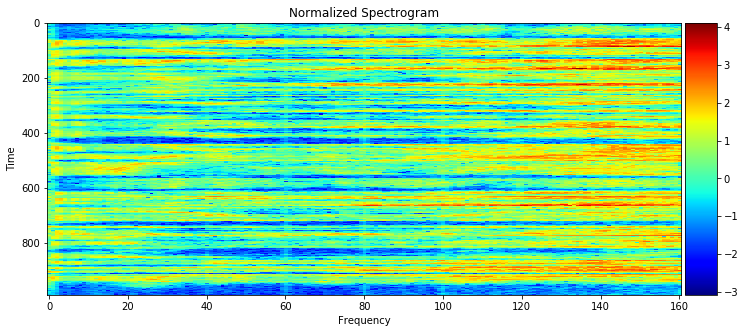

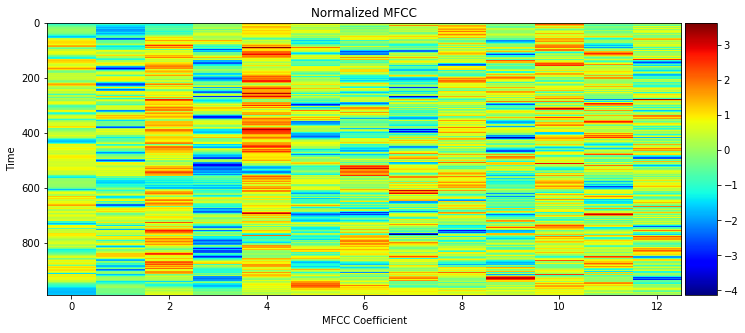

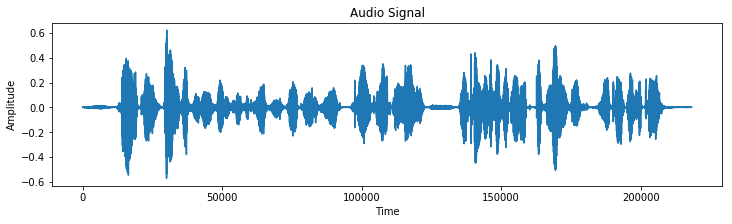

In [17]:
plot_audio_visualizations(index=2)

In [9]:
Audio('F:/data/LibriSpeech/dev-clean/1272/128104/1272-128104-0005.wav')

(107, 161)


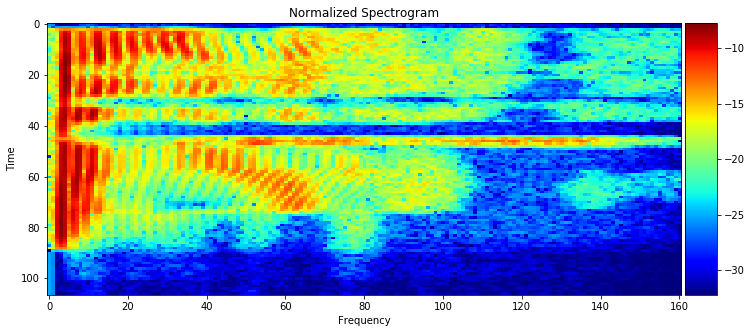

In [20]:
from utils import spectrogram_from_file
q = spectrogram_from_file(filename='audio/example.wav', max_freq=8000)
print(q.shape)
def normalize(samples):
    feat_mean = np.mean(q, axis=0)
    feat_std = np.std(q, axis=0)
    eps = 1e-14
    normalized = (q - feat_mean) / (feat_std + eps)    
    return normalized
plot_spectrogram_feature(q)

In [4]:
# Model custom functions
def clipped_relu(x):
    return relu(x, max_value=20)
def cnn_output_length(input_length, filter_size, border_mode, stride,
                       dilation=1):
    """ Compute the length of the output sequence after 1D convolution along
        time. Note that this function is in line with the function used in
        Convolution1D class from Keras.
    Params:
        input_length (int): Length of the input sequence.
        filter_size (int): Width of the convolution kernel.
        border_mode (str): Only support `same` or `valid`.
        stride (int): Stride size used in 1D convolution.
        dilation (int)
    """
    if input_length is None:
        return None
    assert border_mode in {'same', 'valid'}
    dilated_filter_size = filter_size + (filter_size - 1) * (dilation - 1)
    if border_mode == 'same':
        output_length = input_length
    elif border_mode == 'valid':
        output_length = input_length - dilated_filter_size + 1
    return (output_length + stride - 1) // stride
def ctc(y_true, y_pred):
    return y_pred

In [4]:
"""
 Gabriel Freire: My final compiled Model
 Optimizer: SGD
 Loss: CTC
 file: sample_models.py
"""
my_model = own_model(input_dim=161, output_dim=29)
my_model.load_weights('own_model3.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 200)         354400    
_________________________________________________________________
conv1d_bn (BatchNormalizatio (None, None, 200)         800       
_________________________________________________________________
rnn_1 (GRU)                  (None, None, 256)         350976    
_________________________________________________________________
bn_rnn_1 (BatchNormalization (None, None, 256)         1024      
_________________________________________________________________
rnn_2 (GRU)                  (None, None, 256)         393984    
_________________________________________________________________
bn_rnn_2 (BatchNormalization (None, None, 256)         1024      
__________

In [ ]:
train_my_model(model=my_model, pickle_path='own_model_loss.pickle', save_model_path='own_model4.h5', epochs=10, spectrogram=True)
# train_model(input_to_softmax=model_end, pickle_path='model_end2.pickle', save_model_path='model_end2.h5', spectrogram=True)

Epoch 1/10
135/135 [==============================] - 9989s 74s/step - loss: 402.8234 - val_loss: 332.1536
Epoch 2/10
 93/135 [===================>..........] - ETA: 51:18 - loss: 321.6986

In [11]:
get_predictions(index=2, partition='train', trained_model=my_model, model_path='own_model3.h5')


--------------------------------------------------------------------------------
'LibriSpeech/dev-clean/1272/128104/1272-128104-0003.wav'
True transcription:

he has grave doubts whether sir frederick leighton's work is really greek after all and can discover in it but little of rocky ithaca
--------------------------------------------------------------------------------
Raw prediction:
[[  7.40925543e-09   1.76227338e-10   3.11470899e-07 ...,   1.28648310e-08
    3.25290617e-09   9.99986053e-01]
 [  3.53009710e-09   3.03319696e-12   5.67690641e-08 ...,   7.33242855e-10
    2.96466018e-10   9.99998450e-01]
 [  5.84151394e-09   5.37311623e-13   1.10461995e-08 ...,   4.89486174e-10
    9.43436787e-11   9.99999046e-01]
 ..., 
 [  2.78002735e-05   9.48882880e-05   2.72832713e-05 ...,   8.17647333e-07
    2.48224211e-07   9.99525666e-01]
 [  8.41770379e-05   2.48644326e-04   6.95946073e-05 ...,   1.78094729e-06
    5.99207112e-07   9.98986781e-01]
 [  3.02194967e-04   5.51334757e-04   9.777